# U-Net pour l'analyse de radiographies pulmonaires

Ce notebook implémente un modèle U-Net adapté pour la classification des radiographies thoraciques entre NORMAL et PNEUMONIA.

## Objectifs

1. Implémenter une architecture U-Net adaptée à la classification
2. Entraîner le modèle sur le dataset de radiographies
3. Visualiser les cartes d'activation pour comprendre les décisions du modèle
4. Comparer les performances avec d'autres approches (SVM, ResNet)

In [7]:
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.utils import make_grid
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve
from tqdm.auto import tqdm
import time
from PIL import Image
import copy

BASE_DIR = os.path.abspath("../../")
PROC_DIR = os.path.join(BASE_DIR, "processed")
REPORTS_DIR = os.path.join(BASE_DIR, "reports")
MODELS_DIR = os.path.join(BASE_DIR, "models")
UNET_REPORTS_DIR = os.path.join(REPORTS_DIR, "unet")
CLASSES = ["NORMAL", "PNEUMONIA"]

os.makedirs(UNET_REPORTS_DIR, exist_ok=True)
os.makedirs(MODELS_DIR, exist_ok=True)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Utilisation de: {device}")

plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('viridis')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

print("Configuration terminée.")

Utilisation de: cpu
Configuration terminée.


## 1. Chargement et préparation des données

Nous allons créer un Dataset PyTorch personnalisé pour charger et prétraiter les radiographies. Le prétraitement inclut le redimensionnement, la normalisation et l'augmentation des données.

In [8]:
class ChestXRayDataset(Dataset):
    def __init__(self, split="train", transform=None):
        self.split = split
        self.transform = transform
        self.image_paths = []
        self.labels = []
        
        for idx, cls in enumerate(CLASSES):
            pattern = os.path.join(PROC_DIR, split, cls, "*.png")
            for fp in glob.glob(pattern):
                self.image_paths.append(fp)
                self.labels.append(idx)
        
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        
        image = np.stack([image, image, image], axis=-1)
        
        if self.transform:
            image = self.transform(image)
        
        label = self.labels[idx]
        return image, label

data_transforms = {
    'train': transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((256, 256)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

train_dataset = ChestXRayDataset(split="train", transform=data_transforms['train'])
val_dataset = ChestXRayDataset(split="val", transform=data_transforms['val'])
test_dataset = ChestXRayDataset(split="test", transform=data_transforms['test'])

batch_size = 48
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

print(f"Taille du dataset d'entraînement: {len(train_dataset)}")
print(f"Taille du dataset de validation: {len(val_dataset)}")
print(f"Taille du dataset de test: {len(test_dataset)}")

Taille du dataset d'entraînement: 5216
Taille du dataset de validation: 16
Taille du dataset de test: 624


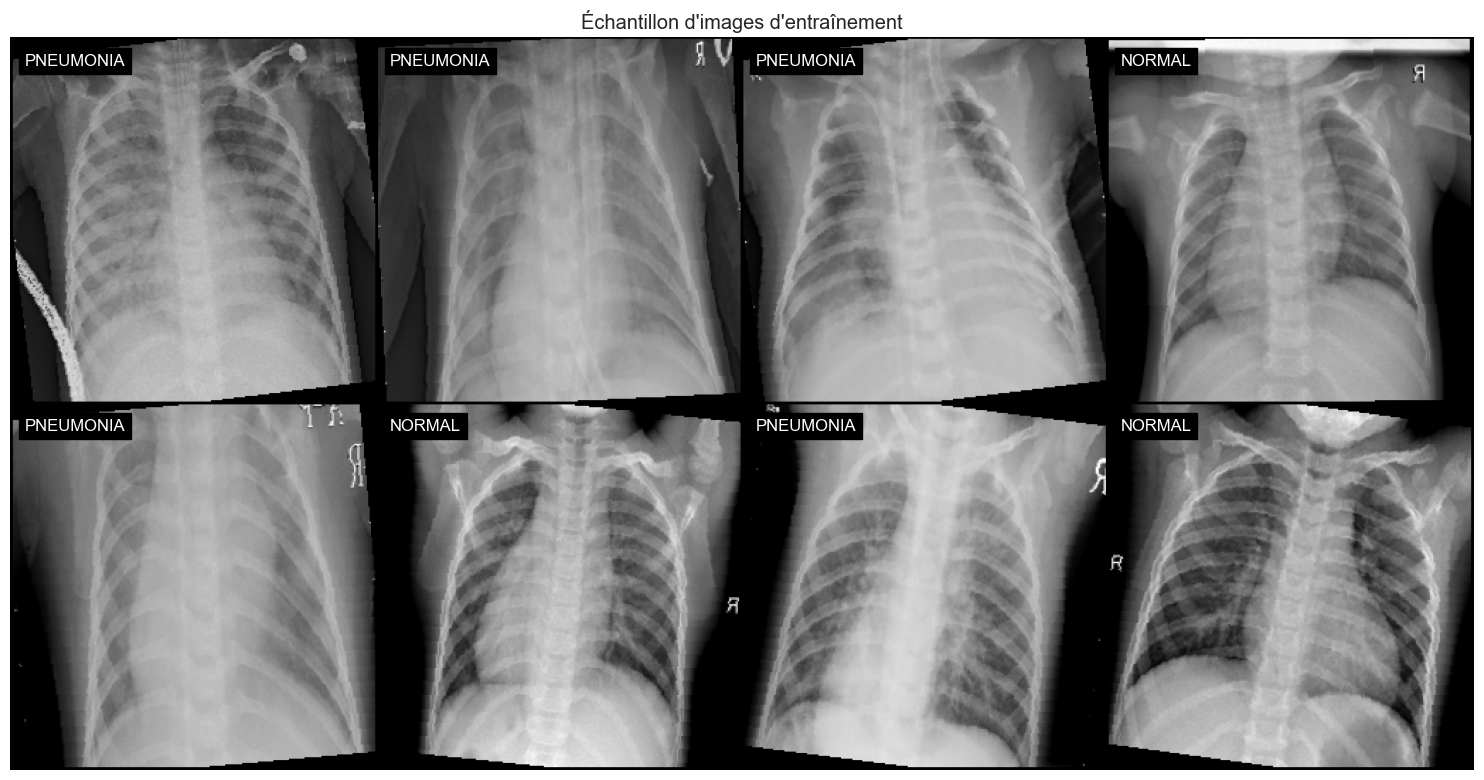

Distribution des classes:
           Train  Validation  Test
NORMAL      1341           8   234
PNEUMONIA   3875           8   390


<Figure size 1200x600 with 0 Axes>

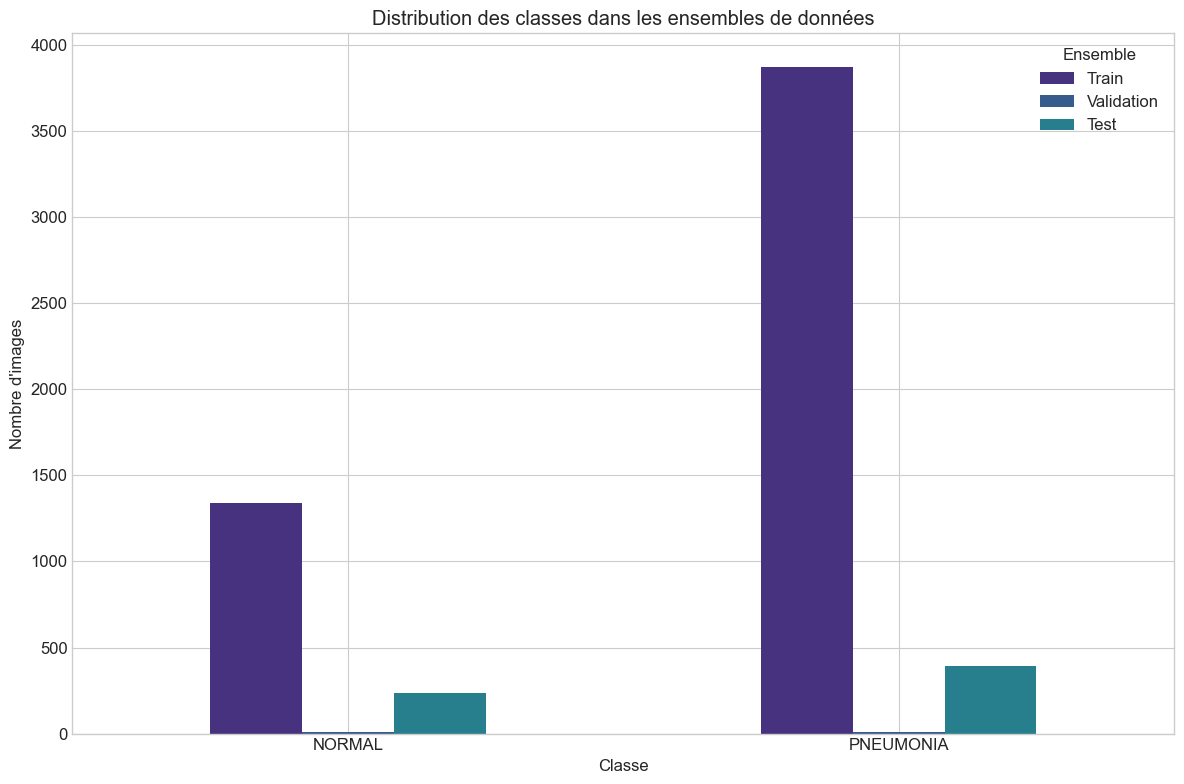

In [9]:
def show_batch(dataloader, num_images=8):
    images, labels = next(iter(dataloader))
    images = images[:num_images]
    labels = labels[:num_images]
    
    mean = torch.tensor([0.485, 0.456, 0.406]).reshape(1, 3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).reshape(1, 3, 1, 1)
    images_display = images * std + mean
    
    grid = make_grid(images_display, nrow=4, normalize=True)
    
    plt.figure(figsize=(15, 8))
    plt.imshow(grid.permute(1, 2, 0))
    plt.title('Échantillon d\'images d\'entraînement')
    plt.axis('off')
    
    for i, label in enumerate(labels):
        row = i // 4
        col = i % 4
        plt.text(col * (256 + 2) + 10, row * (256 + 2) + 20, 
                 f"{CLASSES[label]}", color='white', 
                 backgroundcolor='black', fontsize=12)
    
    plt.tight_layout()
    plt.savefig(os.path.join(UNET_REPORTS_DIR, "sample_training_images.png"), dpi=150)
    plt.show()

show_batch(train_loader)

train_labels = [label for _, label in train_dataset]
val_labels = [label for _, label in val_dataset]
test_labels = [label for _, label in test_dataset]

distribution_df = pd.DataFrame({
    'Train': pd.Series(train_labels).value_counts().sort_index(),
    'Validation': pd.Series(val_labels).value_counts().sort_index(),
    'Test': pd.Series(test_labels).value_counts().sort_index()
})
distribution_df.index = CLASSES

print("Distribution des classes:")
print(distribution_df)

plt.figure(figsize=(12, 6))
distribution_df.plot(kind='bar')
plt.title('Distribution des classes dans les ensembles de données')
plt.xlabel('Classe')
plt.ylabel('Nombre d\'images')
plt.xticks(rotation=0)
plt.legend(title='Ensemble')
plt.tight_layout()
plt.savefig(os.path.join(UNET_REPORTS_DIR, "class_distribution.png"), dpi=150)
plt.show()

## 2. Définition de l'architecture U-Net
U-Net est une architecture en forme de "U" composée d'un chemin de contraction (encodeur) et d'un chemin d'expansion (décodeur) avec des connexions résiduelles.
Bien que U-Net soit généralement utilisé pour la segmentation, nous l'adaptons ici pour la classification.

In [10]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ConvBlock, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
    
    def forward(self, x):
        return self.conv(x)

class DownSample(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DownSample, self).__init__()
        self.conv = ConvBlock(in_channels, out_channels)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
    
    def forward(self, x):
        skip = self.conv(x)
        x = self.pool(skip)
        return x, skip

class UpSample(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UpSample, self).__init__()
        self.up = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)
        self.conv = ConvBlock(in_channels, out_channels)
    
    def forward(self, x, skip):
        x = self.up(x)
        
        diffY = skip.size()[2] - x.size()[2]
        diffX = skip.size()[3] - x.size()[3]
        
        x = F.pad(x, [diffX // 2, diffX - diffX // 2, diffY // 2, diffY - diffY // 2])
        
        x = torch.cat([skip, x], dim=1)
        x = self.conv(x)
        return x

class UNetClassifier(nn.Module):
    def __init__(self, in_channels=3, num_classes=2):
        super(UNetClassifier, self).__init__()
        
        # Encodeur
        self.down1 = DownSample(in_channels, 64)
        self.down2 = DownSample(64, 128)
        self.down3 = DownSample(128, 256)
        self.down4 = DownSample(256, 512)
        
        # Bridge
        self.bridge = ConvBlock(512, 1024)
        
        # Décodeur
        self.up1 = UpSample(1024, 512)
        self.up2 = UpSample(512, 256)
        self.up3 = UpSample(256, 128)
        self.up4 = UpSample(128, 64)
        
        # Module de classification
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64, 32),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(32, num_classes)
        )
        
        # Module pour visualiser l'attention
        self.attention = nn.Conv2d(64, 1, kernel_size=1)
    
    def forward(self, x):
        # Encodeur
        x, skip1 = self.down1(x)
        x, skip2 = self.down2(x)
        x, skip3 = self.down3(x)
        x, skip4 = self.down4(x)
        
        # Bridge
        x = self.bridge(x)
        
        # Décodeur
        x = self.up1(x, skip4)
        x = self.up2(x, skip3)
        x = self.up3(x, skip2)
        x = self.up4(x, skip1)
        
        # Carte d'attention
        attention_map = self.attention(x)
        
        # Classification
        x = self.avgpool(x)
        x = self.classifier(x)
        
        return x, attention_map

model = UNetClassifier(in_channels=3, num_classes=2)
model = model.to(device)

print(model)
print(f"Nombre total de paramètres: {sum(p.numel() for p in model.parameters())}")

UNetClassifier(
  (down1): DownSample(
    (conv): ConvBlock(
      (conv): Sequential(
        (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace=True)
      )
    )
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (down2): DownSample(
    (conv): ConvBlock(
      (conv): Sequential(
        (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): BatchNorm2d(128, eps=1e-05, 

## 3. Fonction d'entraînement

Nous définissons ici les fonctions pour l'entraînement et l'évaluation du modèle U-Net.

In [11]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.5)

def train_model(model, criterion, optimizer, scheduler, num_epochs=5):
    since = time.time()
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    history = {
        'train_loss': [], 'train_acc': [],
        'val_loss': [], 'val_acc': []
    }
    
    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)
        
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Mode entraînement
                dataloader = train_loader
            else:
                model.eval()   # Mode évaluation
                dataloader = val_loader
            
            running_loss = 0.0
            running_corrects = 0
            
            for inputs, labels in tqdm(dataloader, desc=phase):
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                optimizer.zero_grad()
                
                with torch.set_grad_enabled(phase == 'train'):
                    outputs, attention_maps = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            
            epoch_loss = running_loss / len(dataloader.dataset)
            epoch_acc = running_corrects.double() / len(dataloader.dataset)
            
            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
            
            if phase == 'train':
                history['train_loss'].append(epoch_loss)
                history['train_acc'].append(epoch_acc.item())
            else:
                history['val_loss'].append(epoch_loss)
                history['val_acc'].append(epoch_acc.item())
                scheduler.step()
            
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                torch.save(best_model_wts, os.path.join(MODELS_DIR, "unet_best.pth"))
                print(f"Meilleur modèle sauvegardé avec une précision de {best_acc:.4f}")
        
        print()
    
    time_elapsed = time.time() - since
    print(f'Entraînement terminé en {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Meilleure précision de validation: {best_acc:.4f}')
    
    model.load_state_dict(best_model_wts)
    
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='Train')
    plt.plot(history['val_loss'], label='Validation')
    plt.title('Perte')
    plt.xlabel('Epoch')
    plt.ylabel('Perte')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(history['train_acc'], label='Train')
    plt.plot(history['val_acc'], label='Validation')
    plt.title('Précision')
    plt.xlabel('Epoch')
    plt.ylabel('Précision')
    plt.legend()
    
    plt.tight_layout()
    plt.savefig(os.path.join(UNET_REPORTS_DIR, "learning_curves.png"), dpi=150)
    plt.show()
    
    return model, history

## 4. Entraînement du modèle

Nous entraînons maintenant le modèle U-Net sur nos données de radiographies.

In [12]:
model, history = train_model(model, criterion, optimizer, scheduler, num_epochs=5)

torch.save(model.state_dict(), os.path.join(MODELS_DIR, "unet_final.pth"))
print(f"Modèle final sauvegardé dans {os.path.join(MODELS_DIR, 'unet_final.pth')}")

Epoch 1/5
----------


train:   0%|          | 0/109 [00:00<?, ?it/s]

train Loss: 0.5685 Acc: 0.7398


val:   0%|          | 0/1 [00:00<?, ?it/s]

val Loss: 0.5734 Acc: 0.7500
Meilleur modèle sauvegardé avec une précision de 0.7500

Epoch 2/5
----------


train:   0%|          | 0/109 [00:00<?, ?it/s]

KeyboardInterrupt: 

## 5. Évaluation des performances

Nous évaluons maintenant le modèle entraîné sur l'ensemble de test.

Évaluation:   0%|          | 0/13 [00:00<?, ?it/s]

Précision sur test: 0.7997

Rapport de classification détaillé:
              precision    recall  f1-score   support

      NORMAL       0.90      0.53      0.66       234
   PNEUMONIA       0.77      0.96      0.86       390

    accuracy                           0.80       624
   macro avg       0.83      0.74      0.76       624
weighted avg       0.82      0.80      0.78       624



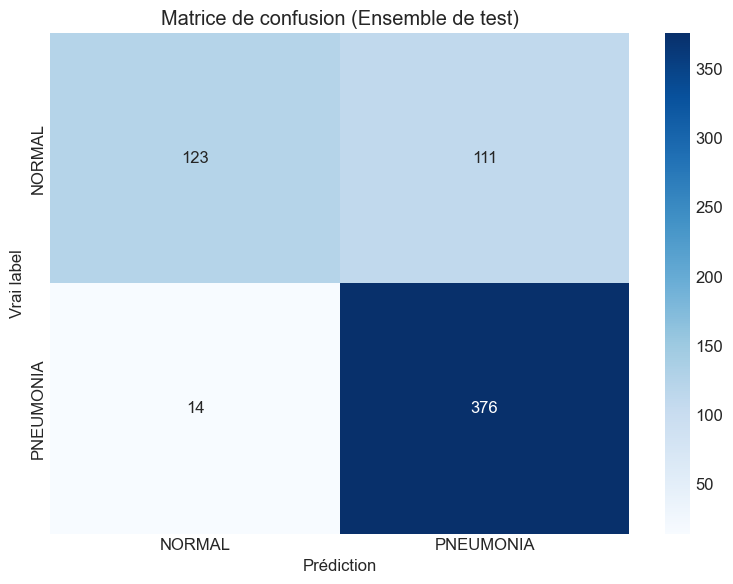

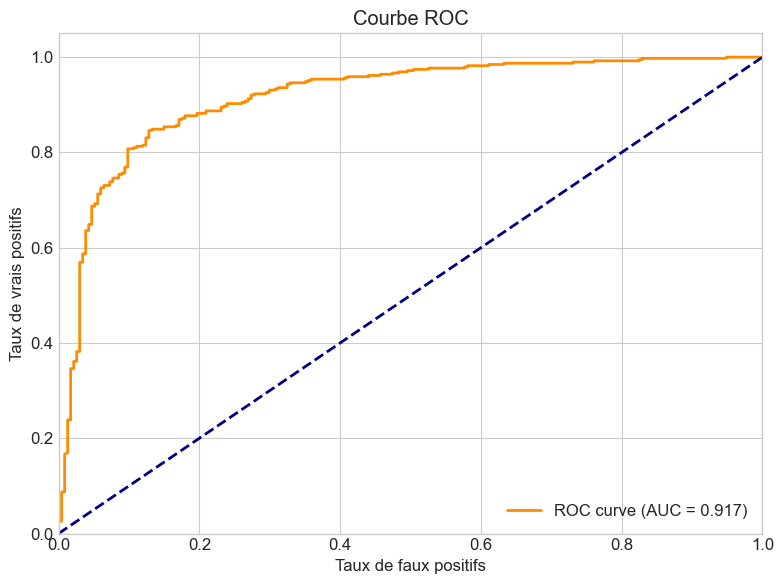

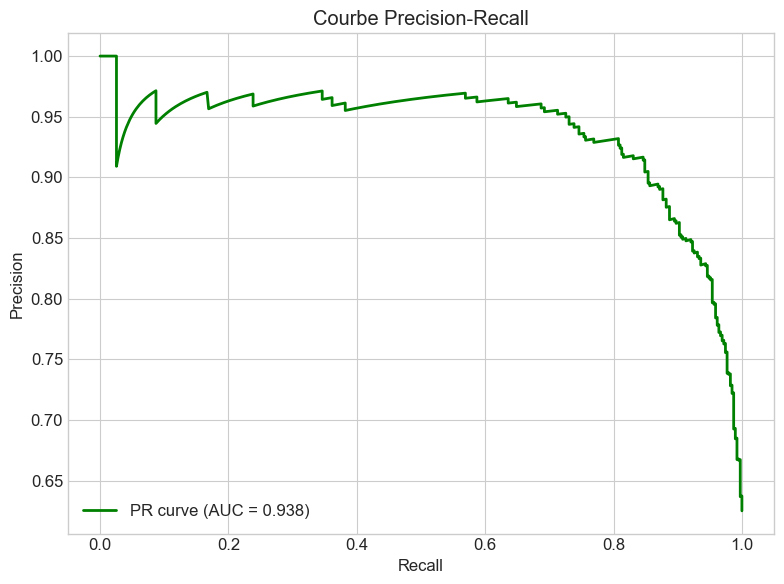


Métriques cliniques importantes:
Sensibilité (Recall PNEUMONIA): 0.9641
Spécificité (Capacité à identifier NORMAL): 0.5256
Valeur prédictive positive (Precision PNEUMONIA): 0.7721
Valeur prédictive négative: 0.8978


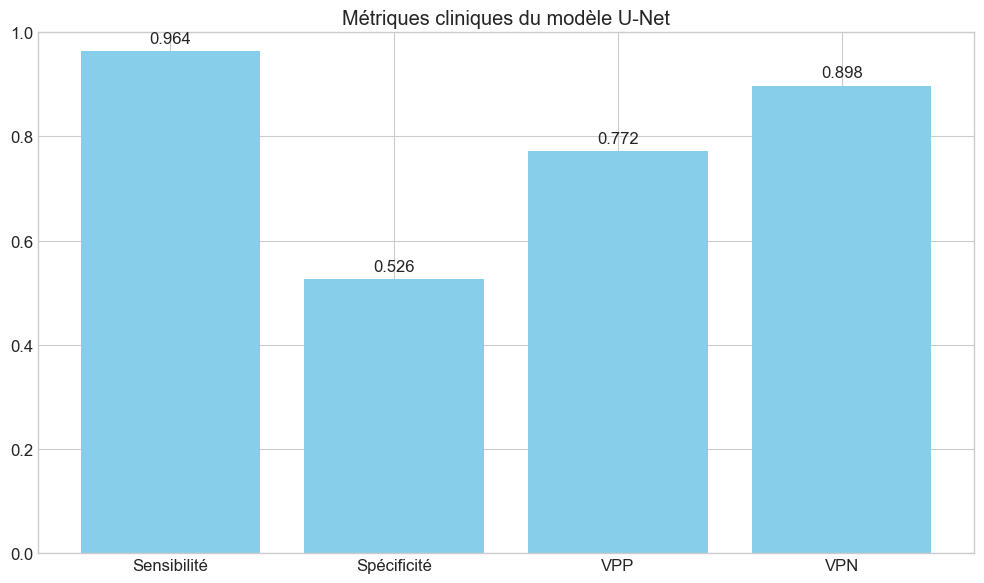

In [13]:
def evaluate_model(model, dataloader):
    model.eval()
    
    y_true = []
    y_pred = []
    y_scores = []
    
    with torch.no_grad():
        for inputs, labels in tqdm(dataloader, desc="Évaluation"):
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs, _ = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            scores = F.softmax(outputs, dim=1)[:, 1]
            
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())
            y_scores.extend(scores.cpu().numpy())
    
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    y_scores = np.array(y_scores)
    
    return y_true, y_pred, y_scores

y_true, y_pred, y_scores = evaluate_model(model, test_loader)

test_accuracy = np.mean(y_true == y_pred)
test_report = classification_report(y_true, y_pred, target_names=CLASSES, output_dict=True)

print(f"Précision sur test: {test_accuracy:.4f}")
print("\nRapport de classification détaillé:")
print(classification_report(y_true, y_pred, target_names=CLASSES))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=CLASSES, yticklabels=CLASSES)
plt.title('Matrice de confusion (Ensemble de test)')
plt.ylabel('Vrai label')
plt.xlabel('Prédiction')
plt.tight_layout()
plt.savefig(os.path.join(UNET_REPORTS_DIR, "confusion_matrix.png"), dpi=150)
plt.show()

fpr, tpr, _ = roc_curve(y_true, y_scores)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taux de faux positifs')
plt.ylabel('Taux de vrais positifs')
plt.title('Courbe ROC')
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(UNET_REPORTS_DIR, "roc_curve.png"), dpi=150)
plt.show()

precision, recall, _ = precision_recall_curve(y_true, y_scores)
pr_auc = auc(recall, precision)
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='green', lw=2, label=f'PR curve (AUC = {pr_auc:.3f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Courbe Precision-Recall')
plt.legend(loc="lower left")
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(UNET_REPORTS_DIR, "precision_recall_curve.png"), dpi=150)
plt.show()

tn, fp, fn, tp = cm.ravel()
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)
ppv = tp / (tp + fp)
npv = tn / (tn + fn)

print("\nMétriques cliniques importantes:")
print(f"Sensibilité (Recall PNEUMONIA): {sensitivity:.4f}")
print(f"Spécificité (Capacité à identifier NORMAL): {specificity:.4f}")
print(f"Valeur prédictive positive (Precision PNEUMONIA): {ppv:.4f}")
print(f"Valeur prédictive négative: {npv:.4f}")

metrics = ['Sensibilité', 'Spécificité', 'VPP', 'VPN']
values = [sensitivity, specificity, ppv, npv]
plt.figure(figsize=(10, 6))
bars = plt.bar(metrics, values, color='skyblue')
plt.ylim([0, 1])
plt.title('Métriques cliniques du modèle U-Net')
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
            f'{height:.3f}', ha='center', va='bottom')
plt.tight_layout()
plt.savefig(os.path.join(UNET_REPORTS_DIR, "clinical_metrics.png"), dpi=150)
plt.show()

## 6. Visualisation des cartes d'attention

Une des forces du modèle U-Net est sa capacité à générer des cartes d'attention qui montrent quelles parties de l'image ont influencé la décision du modèle.

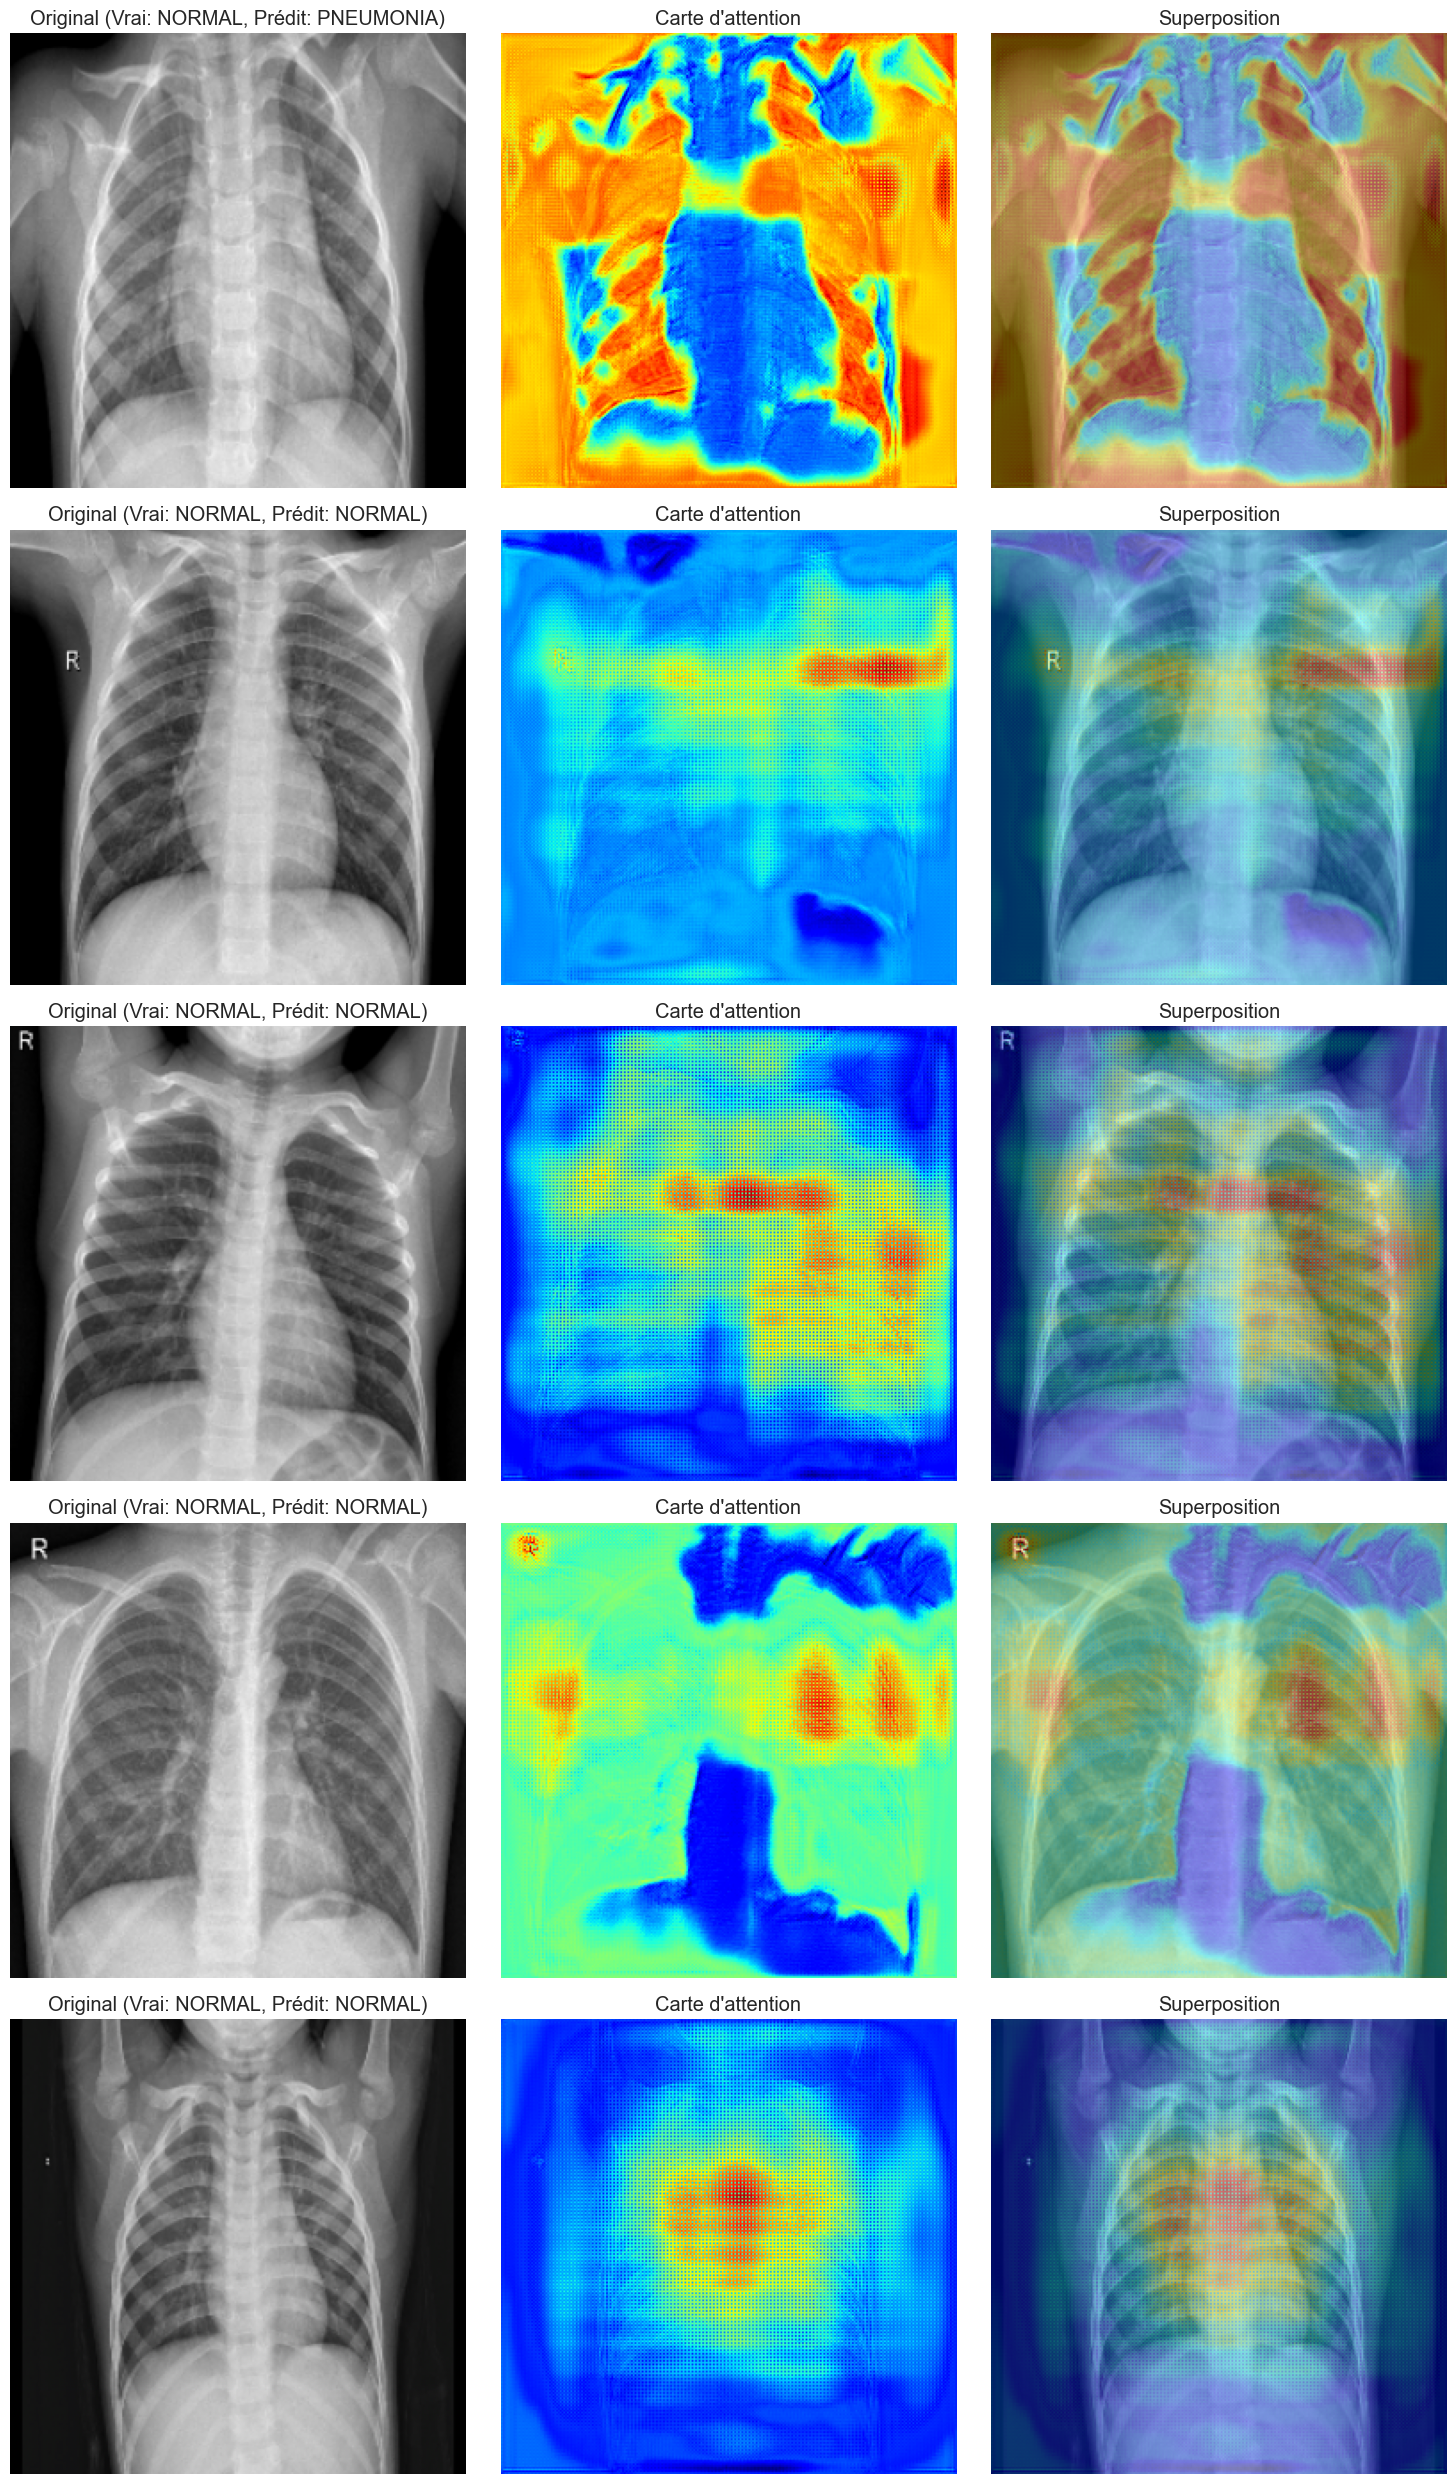

In [14]:
def visualize_attention_maps(model, dataloader, num_images=5):
    model.eval()
    
    dataiter = iter(dataloader)
    batch = next(dataiter)
    images, labels = batch
    
    selected_indices = np.random.choice(len(images), min(num_images, len(images)), replace=False)
    images_selected = images[selected_indices].to(device)
    labels_selected = labels[selected_indices]
    
    with torch.no_grad():
        outputs, attention_maps = model(images_selected)
        _, preds = torch.max(outputs, 1)
    
    fig, axes = plt.subplots(num_images, 3, figsize=(15, 5 * num_images))
    
    for i in range(num_images):
        img = images_selected[i].cpu().permute(1, 2, 0).numpy()
        img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
        img = np.clip(img, 0, 1)
        
        attention = attention_maps[i, 0].cpu().numpy()
        
        attention_resized = cv2.resize(attention, (img.shape[1], img.shape[0]))
        attention_normalized = (attention_resized - attention_resized.min()) / (attention_resized.max() - attention_resized.min())
        heatmap = cv2.applyColorMap(np.uint8(255 * attention_normalized), cv2.COLORMAP_JET)
        heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB) / 255.0
        superimposed = cv2.addWeighted(img, 0.6, heatmap, 0.4, 0)
        
        axes[i, 0].imshow(img)
        axes[i, 0].set_title(f"Original (Vrai: {CLASSES[labels_selected[i]]}, Prédit: {CLASSES[preds[i]]})")
        axes[i, 0].axis('off')
        
        axes[i, 1].imshow(attention_normalized, cmap='jet')
        axes[i, 1].set_title("Carte d'attention")
        axes[i, 1].axis('off')
        
        axes[i, 2].imshow(superimposed)
        axes[i, 2].set_title("Superposition")
        axes[i, 2].axis('off')
    
    plt.tight_layout()
    plt.savefig(os.path.join(UNET_REPORTS_DIR, "attention_maps.png"), dpi=150)
    plt.show()

visualize_attention_maps(model, test_loader, num_images=5)

## 7. Analyse des erreurs

Nous identifions et analysons les cas où le modèle a fait des erreurs de classification.

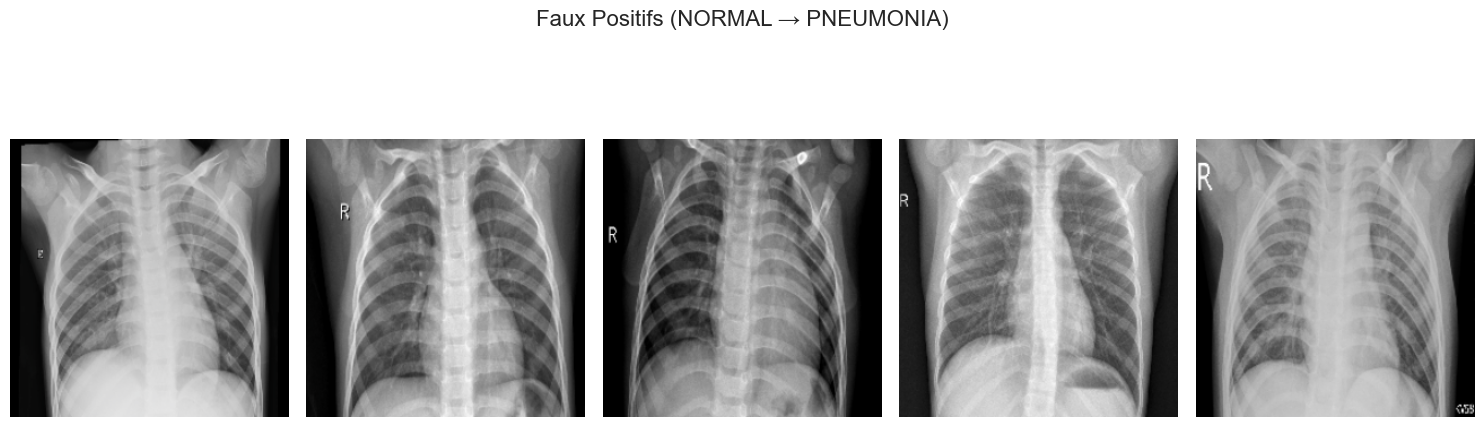

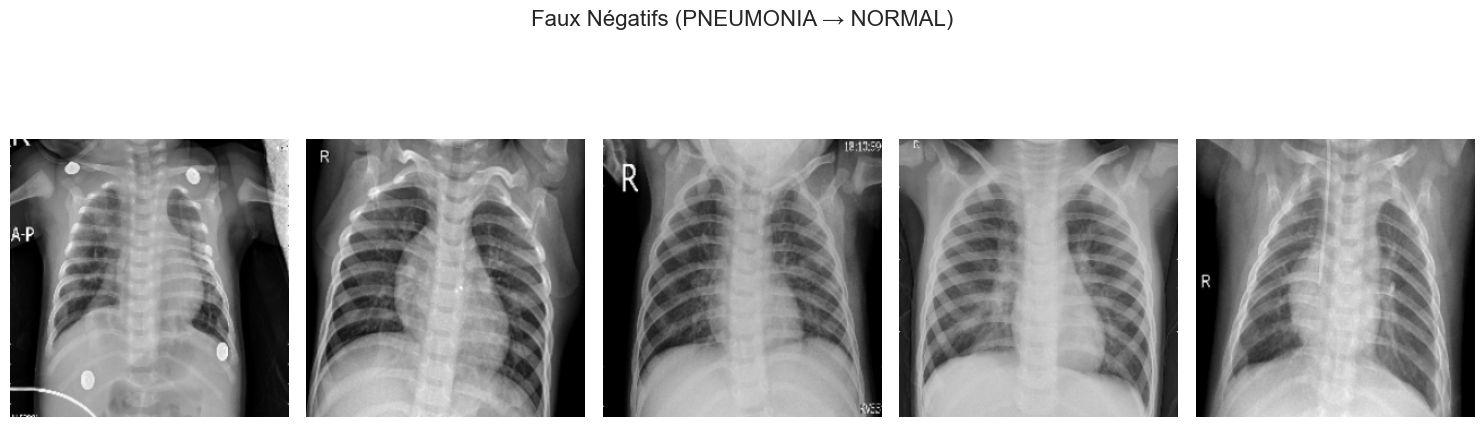

Nombre total d'erreurs analysées: 116
Faux positifs: 111
Faux négatifs: 5


In [15]:
def analyze_errors(model, dataloader, num_examples=5):
    model.eval()
    
    errors = []
    images_fp = []  # Faux positifs
    images_fn = []  # Faux négatifs

    with torch.no_grad():
        for batch_idx, (inputs, labels) in enumerate(dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs, _ = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            error_indices = (preds != labels).nonzero(as_tuple=True)[0]
            
            for idx in error_indices:
                error_type = "FP" if labels[idx] == 0 else "FN"  # FP = NORMAL classé comme PNEUMONIA
                
                img = inputs[idx].cpu()
                if error_type == "FP":
                    images_fp.append(img)
                else:
                    images_fn.append(img)
                
                errors.append({
                    "batch_idx": batch_idx,
                    "image_idx": idx.item(),
                    "true_label": labels[idx].item(),
                    "pred_label": preds[idx].item(),
                    "error_type": error_type
                })
                
                if len(images_fp) >= num_examples and len(images_fn) >= num_examples:
                    break
            
            if len(images_fp) >= num_examples and len(images_fn) >= num_examples:
                break
    
    if images_fp:
        plt.figure(figsize=(15, 5))
        plt.suptitle("Faux Positifs (NORMAL → PNEUMONIA)", fontsize=16)
        
        for i, img in enumerate(images_fp[:num_examples]):
            plt.subplot(1, num_examples, i+1)
            
            img = img.permute(1, 2, 0).numpy()
            img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
            img = np.clip(img, 0, 1)
            
            plt.imshow(img)
            plt.axis('off')
        
        plt.tight_layout()
        plt.subplots_adjust(top=0.85)
        plt.savefig(os.path.join(UNET_REPORTS_DIR, "false_positives.png"), dpi=150)
        plt.show()
    
    if images_fn:
        plt.figure(figsize=(15, 5))
        plt.suptitle("Faux Négatifs (PNEUMONIA → NORMAL)", fontsize=16)
        
        for i, img in enumerate(images_fn[:num_examples]):
            plt.subplot(1, num_examples, i+1)
            
            img = img.permute(1, 2, 0).numpy()
            img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
            img = np.clip(img, 0, 1)
            
            plt.imshow(img)
            plt.axis('off')
        
        plt.tight_layout()
        plt.subplots_adjust(top=0.85)
        plt.savefig(os.path.join(UNET_REPORTS_DIR, "false_negatives.png"), dpi=150)
        plt.show()
    
    if errors:
        fp_count = sum(1 for e in errors if e["error_type"] == "FP")
        fn_count = sum(1 for e in errors if e["error_type"] == "FN")
        
        print(f"Nombre total d'erreurs analysées: {len(errors)}")
        print(f"Faux positifs: {fp_count}")
        print(f"Faux négatifs: {fn_count}")
    else:
        print("Aucune erreur trouvée dans les lots analysés.")

analyze_errors(model, test_loader)

## 8. Comparaison avec d'autres modèles

Nous comparons maintenant les performances du modèle U-Net avec les résultats obtenus par le SVM et d'autres modèles dans les notebooks précédents.

Comparaison des performances:
      Métrique     U-Net       SVM
0    Précision  0.799679  0.762821
1  Sensibilité  0.964103  0.994872
2  Spécificité  0.525641  0.376068
3          VPP  0.772074       NaN
4          VPN  0.897810       NaN


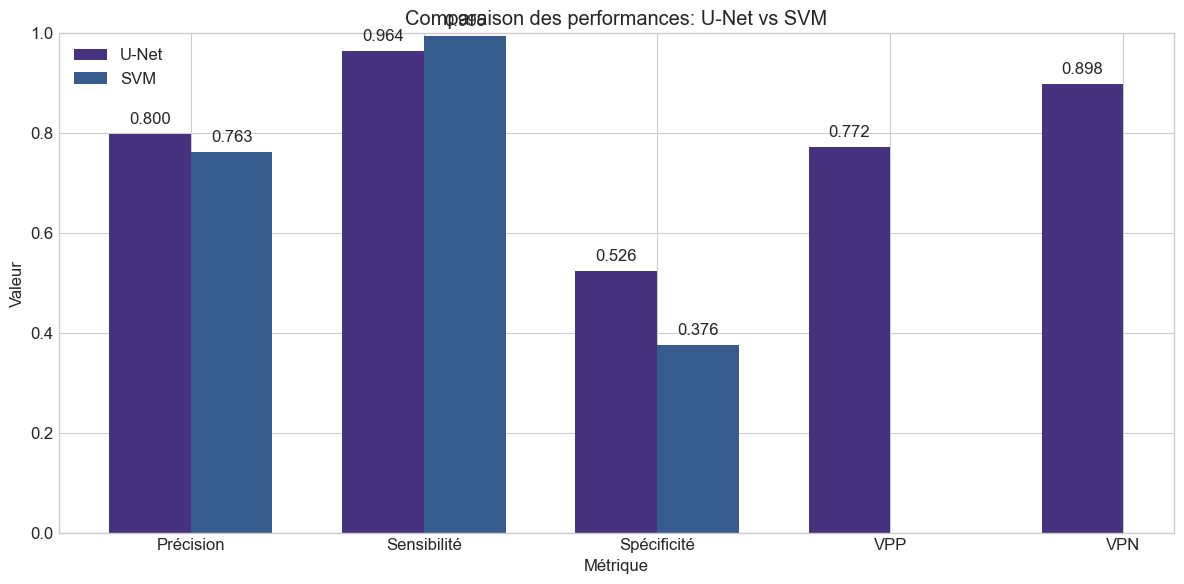

In [16]:
try:
    svm_summary = pd.read_csv(os.path.join(REPORTS_DIR, "svm", "performance_summary.csv"))
    
    comparison_data = {
        'Métrique': ['Précision', 'Sensibilité', 'Spécificité', 'VPP', 'VPN'],
        'U-Net': [test_accuracy, sensitivity, specificity, ppv, npv]
    }
    
    for metric in comparison_data['Métrique']:
        metric_row = svm_summary[svm_summary['Métrique'] == metric]
        if not metric_row.empty:
            comparison_data.setdefault('SVM', []).append(metric_row['Valeur'].values[0])
        else:
            comparison_data.setdefault('SVM', []).append(None)
    
    comparison_df = pd.DataFrame(comparison_data)
    
    print("Comparaison des performances:")
    print(comparison_df)
    
    metrics = comparison_df['Métrique']
    unet_values = comparison_df['U-Net']
    svm_values = comparison_df['SVM']
    
    x = np.arange(len(metrics))
    width = 0.35
    
    plt.figure(figsize=(12, 6))
    plt.bar(x - width/2, unet_values, width, label='U-Net')
    plt.bar(x + width/2, svm_values, width, label='SVM')
    
    plt.xlabel('Métrique')
    plt.ylabel('Valeur')
    plt.title('Comparaison des performances: U-Net vs SVM')
    plt.xticks(x, metrics)
    plt.ylim(0, 1)
    plt.legend()
    
    for i, v in enumerate(unet_values):
        plt.text(i - width/2, v + 0.02, f'{v:.3f}', ha='center')
    
    for i, v in enumerate(svm_values):
        if v is not None:
            plt.text(i + width/2, v + 0.02, f'{v:.3f}', ha='center')
    
    plt.tight_layout()
    plt.savefig(os.path.join(UNET_REPORTS_DIR, "model_comparison.png"), dpi=150)
    plt.show()
    
    comparison_df.to_csv(os.path.join(UNET_REPORTS_DIR, "model_comparison.csv"), index=False)
    
except Exception as e:
    print(f"Impossible de charger les résultats du SVM: {e}")
    print("Veuillez exécuter le notebook SVM avant de faire la comparaison.")